In [18]:
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
def scrape_cat_wikipedia():
    """Scrape the cat Wikipedia article"""
    url = "https://en.wikipedia.org/wiki/Cat"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Get the article content
    content = soup.find('div', {'id': 'mw-content-text'})
    paragraphs = []

    if content:
        # Get all paragraphs
        paragraph_elements = content.find_all('p')
        for p in paragraph_elements:
            text = p.get_text()
            # Clean text
            text = re.sub(r'\[.*?\]', '', text)  # Remove [citations]
            if len(text.strip()) > 0:  # Skip empty paragraphs
                paragraphs.append(text)

    full_text = ' '.join(paragraphs)
    return full_text

# Get the cat article text
cat_text = scrape_cat_wikipedia()
print(f"Total characters scraped: {len(cat_text)}")
print(f"Preview of the first 200 characters:\n{cat_text[:200]}...")


Total characters scraped: 46710
Preview of the first 200 characters:
The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology...


In [20]:



def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Preprocess the cat text
processed_text = preprocess_text(cat_text)
print(f"Total characters after preprocessing: {len(processed_text)}")
print(f"Preview after preprocessing:\n{processed_text[:200]}...")





Total characters after preprocessing: 44789
Preview after preprocessing:
the cat felis catus also referred to as the domestic cat or house cat is a small domesticated carnivorous mammal it is the only domesticated species of the family felidae advances in archaeology and g...


In [21]:
def create_sequences(text, seq_length=3):
    """Create input-output sequence pairs for training"""
    words = text.split()
    sequences = []
    targets = []

    for i in range(len(words) - seq_length):
        seq = words[i:i+seq_length]
        target = words[i+seq_length]
        sequences.append(seq)
        targets.append(target)

    return sequences, targets

# Create sequences with 3 words of context
seq_length = 3
sequences, targets = create_sequences(processed_text, seq_length)

print(f"Total sequences created: {len(sequences)}")
print(f"Example sequences:\n{sequences[:3]}")
print(f"Corresponding targets:\n{targets[:3]}")

Total sequences created: 7494
Example sequences:
[['the', 'cat', 'felis'], ['cat', 'felis', 'catus'], ['felis', 'catus', 'also']]
Corresponding targets:
['catus', 'also', 'referred']


In [22]:
# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([processed_text])
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert sequences to numerical form
X = tokenizer.texts_to_sequences(sequences)
X = np.array(X)

# Create one-hot encoded targets
y = tokenizer.texts_to_sequences(targets)
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)


Vocabulary size: 2290


In [23]:
def build_gru_model(vocab_size, embedding_dim=100, gru_units=128, seq_length=3):
    """Build a GRU-based next word prediction model"""
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
        GRU(gru_units, return_sequences=False),
        Dropout(0.2),
        Dense(vocab_size, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [25]:
# Create the model
embedding_dim = 100
gru_units = 128
model = build_gru_model(vocab_size, embedding_dim, gru_units, seq_length)
model.build(input_shape=(None, vocab_size))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 2290, 100)      │       229,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2290)           │       295,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 612,730 (2.34 MB)

 Trainable params: 612,730 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint('cat_gru_model.h5', save_best_only=True, monitor='val_loss')
]

# Split data into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1077 - loss: 5.3684

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1076 - loss: 5.3682 - val_accuracy: 0.0907 - val_loss: 7.9033
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1225 - loss: 5.1041 - val_accuracy: 0.0841 - val_loss: 8.0616
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1419 - loss: 4.8237 - val_accuracy: 0.0801 - val_loss: 8.1852
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1648 - loss: 4.5162 - val_accuracy: 0.0821 - val_loss: 8.3062
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1845 - loss: 4.2194 - val_accuracy: 0.0807 - val_loss: 8.4860
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2193 - loss: 3.9016 - val_accuracy: 0.0794 - val_loss: 8.6430
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2601 - loss: 3.5931 - val_accuracy: 0.0747 - val_loss: 8.8283
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3213 - loss: 3.2830 - val_accuracy: 0.075

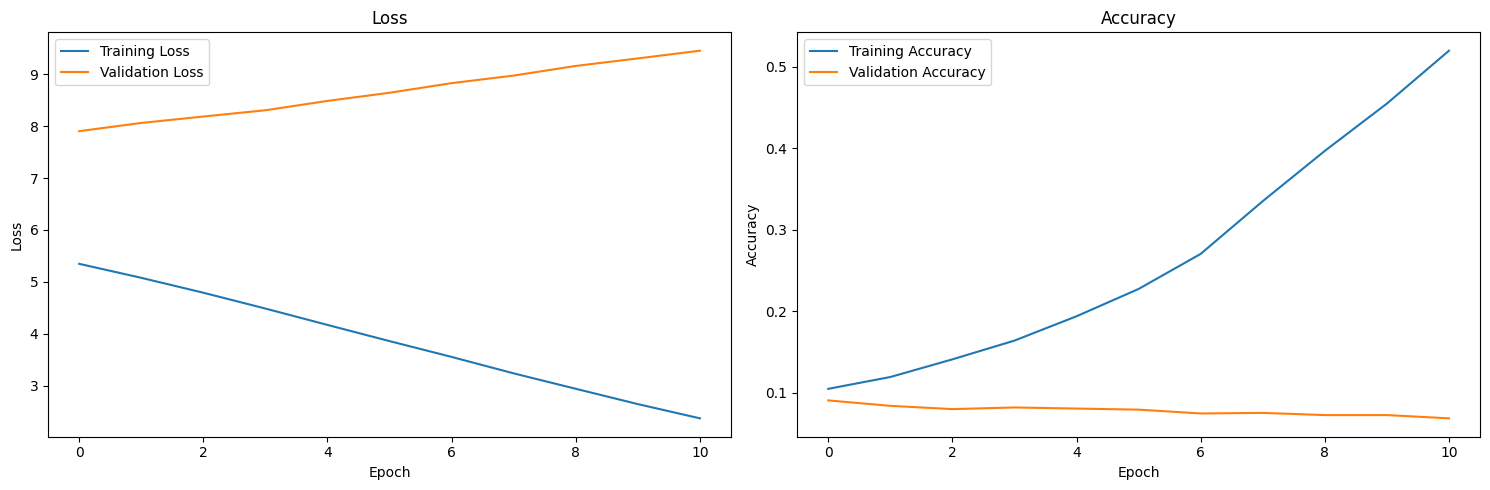

In [28]:
# Cell 8: Plot training history
def plot_training_history(history):
    """Plot training and validation loss/accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [29]:
# Cell 9: Define prediction function
def predict_next_word(model, input_text, tokenizer, seq_length=3, num_predictions=5):
    """Predict the next word after the given input text"""
    # Preprocess input text
    input_text = preprocess_text(input_text)

    # Get the last seq_length words
    words = input_text.split()
    if len(words) < seq_length:
        print(f"Input text must contain at least {seq_length} words")
        return []

    input_seq = words[-seq_length:]

    # Convert to numerical form
    input_seq_num = tokenizer.texts_to_sequences([input_seq])[0]

    # Predict probabilities for all words
    predictions = model.predict(np.array([input_seq_num]))[0]

    # Get top N predictions
    top_indices = predictions.argsort()[-num_predictions:][::-1]

    # Convert indices back to words
    index_to_word = {v: k for k, v in tokenizer.word_index.items()}
    top_words = [index_to_word.get(idx, "UNKNOWN") for idx in top_indices]
    top_probs = [predictions[idx] for idx in top_indices]

    return list(zip(top_words, top_probs))


In [30]:
# Cell 10: Test predictions with cat-related phrases
cat_phrases = [
    "cats are domestic",
    "cats have retractable",
    "the domestic cat",
    "cats can live",
    "felines are known"
]

for phrase in cat_phrases:
    predictions = predict_next_word(model, phrase, tokenizer, seq_length, num_predictions=3)
    print(f"\nInput: '{phrase}'")
    print("Predicted next words:")
    for word, prob in predictions:
        print(f"{word}: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step

Input: 'cats are domestic'
Predicted next words:
cats: 0.5602
cat: 0.1987
animals: 0.0497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Input: 'cats have retractable'
Predicted next words:
most: 0.1041
claws: 0.0827
female: 0.0625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Input: 'the domestic cat'
Predicted next words:
is: 0.2054
has: 0.1424
in: 0.0601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Input: 'cats can live'
Predicted next words:
them: 0.0729
alone: 0.0725
–: 0.0516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Input: 'felines are known'
Predicted next words:
to: 0.1870
as: 0.1770
in: 0.1463


In [31]:
# Cell 11: Define sentence generation function
def generate_sentence(model, seed_text, tokenizer, seq_length=3, max_length=20):
    """Generate a sentence starting with the seed text"""
    # Preprocess seed text
    current_text = preprocess_text(seed_text)

    # Generate words
    for _ in range(max_length):
        # Get the most recent seq_length words
        words = current_text.split()
        if len(words) < seq_length:
            break

        input_seq = words[-seq_length:]

        # Convert to numerical form
        input_seq_num = tokenizer.texts_to_sequences([input_seq])[0]

        # Predict next word
        predictions = model.predict(np.array([input_seq_num]))[0]
        next_word_idx = np.argmax(predictions)

        # Convert index to word
        index_to_word = {v: k for k, v in tokenizer.word_index.items()}
        next_word = index_to_word.get(next_word_idx, "UNKNOWN")

        # Add the predicted word to the current text
        current_text += " " + next_word

    return current_text

In [32]:
# Cell 12: Generate sentences with cat-related seed texts
seed_texts = [
    "cats are known for",
    "domestic cats typically",
    "the average cat can"
]

for seed in seed_texts:
    generated = generate_sentence(model, seed, tokenizer, seq_length, max_length=15)
    print(f"\nSeed: '{seed}'")
    print(f"Generated: '{generated}'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Seed: 'cats are known for'
Generated: 'cats are known for humans and other domestic cats are generally fond of perching and high quickly to be'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━

In [33]:
# Cell 13: Define comparison function for GRU vs LSTM
def compare_gru_vs_lstm(X_train, y_train, X_val, y_val, vocab_size, embedding_dim=100, units=128, seq_length=3):
    """Compare GRU and LSTM models for next word prediction"""
    # Build GRU model
    gru_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
        GRU(units, return_sequences=False),
        Dropout(0.2),
        Dense(vocab_size, activation='softmax')
    ])

    gru_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Build LSTM model
    lstm_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
        tf.keras.layers.LSTM(units, return_sequences=False),
        Dropout(0.2),
        Dense(vocab_size, activation='softmax')
    ])

    lstm_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train GRU model
    gru_history = gru_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=0
    )

    # Train LSTM model
    lstm_history = lstm_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=0
    )

    # Plot comparison
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(gru_history.history['val_loss'], label='GRU')
    plt.plot(lstm_history.history['val_loss'], label='LSTM')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(gru_history.history['val_accuracy'], label='GRU')
    plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return final metrics
    gru_val_loss = gru_history.history['val_loss'][-1]
    gru_val_acc = gru_history.history['val_accuracy'][-1]

    lstm_val_loss = lstm_history.history['val_loss'][-1]
    lstm_val_acc = lstm_history.history['val_accuracy'][-1]

    print(f"GRU - Val Loss: {gru_val_loss:.4f}, Val Accuracy: {gru_val_acc:.4f}")
    print(f"LSTM - Val Loss: {lstm_val_loss:.4f}, Val Accuracy: {lstm_val_acc:.4f}")


Comparing GRU vs LSTM performance:


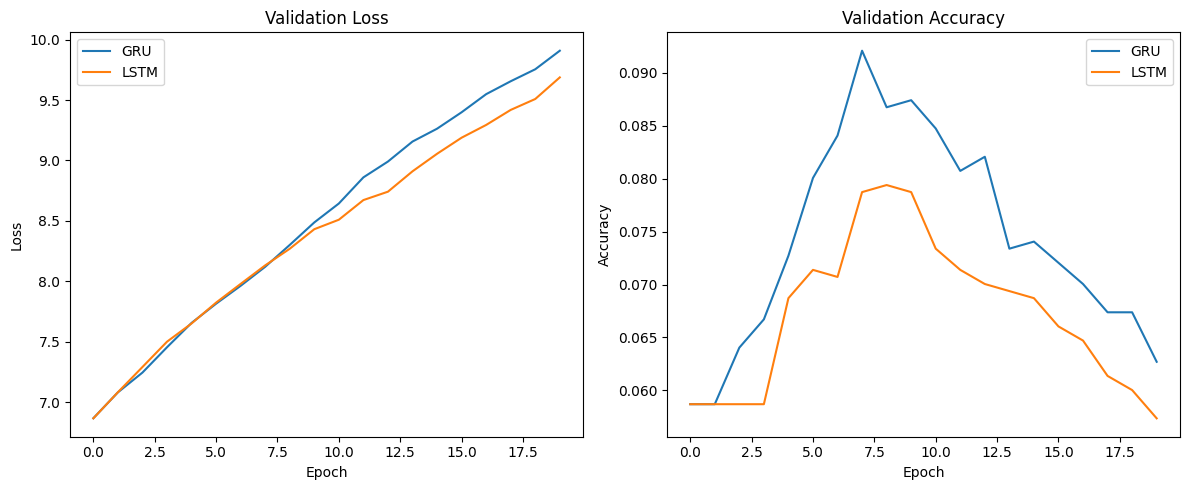

GRU - Val Loss: 9.9076, Val Accuracy: 0.0627
LSTM - Val Loss: 9.6870, Val Accuracy: 0.0574


In [35]:
#  Cell 14: Compare GRU and LSTM models
print("\nComparing GRU vs LSTM performance:")
compare_gru_vs_lstm(X_train, y_train, X_val, y_val, vocab_size, embedding_dim, gru_units, seq_length)

In [36]:
# Cell 15: Save the model and tokenizer
def save_model_and_tokenizer(model, tokenizer, model_path='cat_gru_model.h5', tokenizer_path='cat_tokenizer.pickle'):
    """Save the trained model and tokenizer"""
    model.save(model_path)
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Model saved to {model_path}")
    print(f"Tokenizer saved to {tokenizer_path}")

# Save the model and tokenizer
save_model_and_tokenizer(model, tokenizer)

print("\nModel training and evaluation complete!")

Model saved to cat_gru_model.h5
Tokenizer saved to cat_tokenizer.pickle

Model training and evaluation complete!
